In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
mpl.rc('font', family='serif', size=11)
mpl.rc('savefig', bbox='tight')

import dtw
import worg

make_fname_safe = lambda s: s.lower().replace(' ', '-')

/home/scopatz/miniconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/scopatz/miniconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)
/home/scopatz/miniconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.enrichment is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
T = 50
seed = 424242
verbose = True
f = 90 * (1.01**np.arange(T))  # 1% growth
g0 = np.zeros(T, dtype='f8')    # zero production
N = np.asarray(np.ceil(4*(1.01)**np.arange(T)), dtype=int)

DTW
======

In [3]:
def display_dwt(dist, cost, path, xname, yname, offset=2016, vmax=None):
    fig = plt.figure(figsize=(8, 6))
    extent = (offset, offset+cost.shape[1], offset, offset+cost.shape[0])
    plt.imshow(cost[::-1], cmap='viridis', extent=extent, vmin=0.0, vmax=vmax)
    u = offset + np.concatenate([path, np.array([[cost.shape[1]], [cost.shape[0]]])], axis=1)
    plt.plot(u[1], u[0], 'w-')
    plt.axis(extent)
    cb = plt.colorbar()
    cb.set_label('Cost [GWe]', rotation=-90, va='bottom')
    plt.xlabel('time [year]')
    plt.ylabel('time [year]')
    fname = 'cost-{0}-to-{1}'.format(make_fname_safe(xname), make_fname_safe(yname))
    plt.savefig(fname + '.png')
    plt.savefig(fname + '.eps')
    print('Warping between {0} and {1}:'.format(xname, yname))
    print('  Distance is ', dist)

Warping between Demand and Production:
  Distance is  0.755990232857


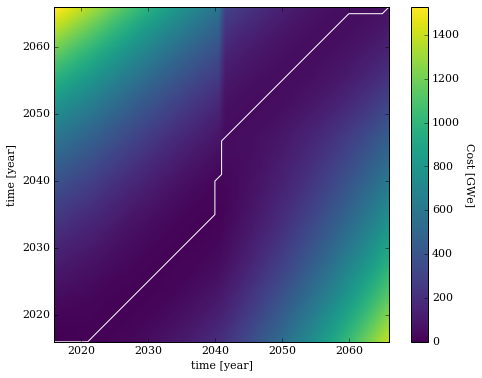

In [4]:
p = np.empty(T, dtype='f8')
p[:T//2] = f[:T//2] * 0.95
p[T//2:] = f[T//2:] * 1.05
dist, cost, path = dtw.dtw(f[:,np.newaxis], p[:,np.newaxis])
display_dwt(dist, cost, path, 'Demand', 'Production')

GP
=======

In [5]:
def model_plot(t, y, yerr, tpred, mu, std, title=None, ymax=None):
    fig = plt.figure(figsize=(8, 8))
    #plt.errorbar(t, y, yerr, fmt='r.', label='training data')
    plt.plot(t, y, 'r.', label='training data')
    plt.plot(tpred, mu, 'k-', label='model')
    plt.fill_between(tpred, mu - 2*std, mu + 2*std, color='gray')
    ax = plt.axis()
    plt.axis([tpred[0], tpred[-1], 0.0, ymax or ax[3]])
    plt.legend(loc=0)
    plt.xlabel('time [year]')
    plt.ylabel('Power Production [GWe]')
    if title:
        plt.title(title)
    fbase = 'gwe-model-' + (title or '').lower().replace(' ', '-')
    plt.savefig(fbase + '.eps')
    plt.savefig(fbase + '.png')

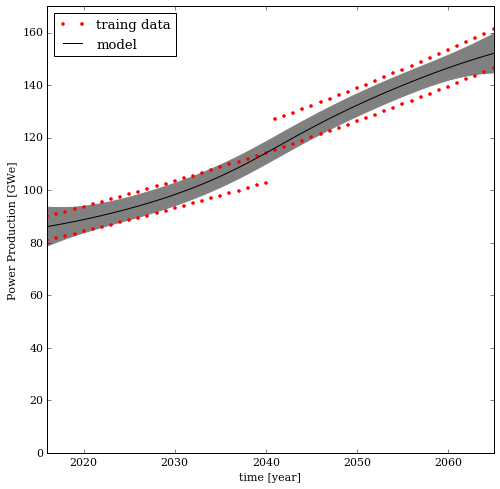

In [6]:
tol = 1e-1
q = np.empty(T, dtype='f8')
q[:T//2] = f[:T//2] * 0.9
q[T//2:] = f[T//2:] * 1.1
gp, x, y = worg.gp_gwe([N, N], [f, q], T, tol, N)
mu, cov = gp.predict(y, x[:T])
std = np.sqrt(np.diag(cov))
model_plot(x[:,0]+2016, y, 0.0, x[:T,0] + 2016, mu, std)

Optimizations
========

In [7]:
T = 20

def run_percent_growth(rate, f0=90.0, N0=10, T=T, seed=seed, verbose=verbose, **kwargs):
    r = 1.0 + (rate/100.0)
    tgrid = np.arange(T)
    f = f0 * (r**tgrid)
    N = np.asarray(np.ceil(N0*(r**tgrid)), dtype=int)
    state = worg.optimize(f, N, seed=seed, verbose=verbose, **kwargs)
    return state

In [8]:
%time state0sto = run_percent_growth(0, MAX_S=20, method_0='stochastic')

Simulation 3
------------
SimId 2310b8e0-58d8-4f13-9c55-e27833aac440
hyperparameters: [ 8.2593187   4.52500623]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.9735634326934814 sec
Simulation time: 0.0 min 4.129423141479492 sec
D_s: 3.1791666666666365
D: [3.1791666666666365, 9.8083333333332412]

Simulation 4
------------
SimId fc392745-4522-45d9-ae4f-5548bc6a2729
hyperparameters: [ 5.08301056  3.40378271]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.9823391437530518 sec
Simulation time: 0.0 min 4.878907680511475 sec
D_s: 5.937499999999323
D: [3.1791666666666365, 5.9374999999993232]

Simulation 5
------------
SimId 25bc55eb-5c57-41f3-85fe-1fee24621696
hyperparameters: [ 4.66739622  2.47710559]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.020625114440918 sec
Simulation time: 0.0 min 4.770863056182861 sec
D_s: 2.0187499999999607
D: [2.0187499999999607, 3.1

In [9]:
%time state0inn = run_percent_growth(0, MAX_S=20, method_0='inner-prod')

Simulation 3
------------
SimId d0aa25f0-dc17-4426-bbcd-d5df7952bf3d
hyperparameters: [ 8.2593187   4.52500623]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.3671538829803467 sec
Simulation time: 0.0 min 3.881606340408325 sec
D_s: 3.4541666666666964
D: [3.4541666666666964, 9.8083333333332412]

Simulation 4
------------
SimId 1c58f1c6-3002-4bef-8182-e43cd1e464b5
hyperparameters: [ 4.96939389  3.35689812]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.453777551651001 sec
Simulation time: 0.0 min 4.295544385910034 sec
D_s: 2.1250000000000298
D: [2.1250000000000298, 3.4541666666666964]

Simulation 5
------------
SimId 694d04fc-72df-4c7f-81c5-766e709a5f48
hyperparameters: [ 3.13957111  1.93044129]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.3632781505584717 sec
Simulation time: 0.0 min 4.716221809387207 sec
D_s: 2.002083333333408
D: [2.0020833333334078, 2.1

In [10]:
%time state0all = run_percent_growth(0, MAX_S=20, method_0='all')

Simulation 3
------------
SimId 4641035b-6bf5-414a-b529-7eb39f1a0d54
hyperparameters: [ 8.2593187   4.52500623]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.2169685363769531 sec
Simulation time: 0.0 min 3.781930923461914 sec
D_s: 3.4541666666666964
D: [3.4541666666666964, 9.8083333333332412]

Simulation 4
------------
SimId 1f546da2-95e9-4ac3-9140-914368cd5584
hyperparameters: [ 4.96939389  3.35689812]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.261075496673584 sec
Simulation time: 0.0 min 4.446516752243042 sec
D_s: 2.1250000000000298
D: [2.1250000000000298, 3.4541666666666964]

Simulation 5
------------
SimId e3303f8c-33fc-493e-912f-0c3e2cf8ef0c
hyperparameters: [ 3.13957111  1.93044129]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.9203791618347168 sec
Simulation time: 0.0 min 4.719269037246704 sec
D_s: 3.9145833333327347
D: [2.1250000000000298, 3.45416666666669

In [11]:
%time state1sto = run_percent_growth(1, MAX_S=20, method_0='stochastic')

Simulation 3
------------
SimId f7eab166-21b3-43d5-a84b-a3e155021cbf
hyperparameters: [ 8.58728406  4.5605898 ]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.0099830627441406 sec
Simulation time: 0.0 min 3.9000790119171143 sec
D_s: 5.952819776625992
D: [5.9528197766259918, 14.30609232162578]

Simulation 4
------------
SimId 830c9c37-ad01-4548-bf5f-99961fba94fe
hyperparameters: [ 5.31310779  3.62122666]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.1100702285766602 sec
Simulation time: 0.0 min 4.487576007843018 sec
D_s: 1.0913573738881053
D: [1.0913573738881053, 5.9528197766259918]

Simulation 5
------------
SimId efdf8a30-2c26-4fad-a1ed-4ef1be6e3692
hyperparameters: [ 4.45135636  2.60789788]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.0585527420043945 sec
Simulation time: 0.0 min 4.942779302597046 sec
D_s: 2.701777228550989
D: [1.0913573738881053, 2.7

In [12]:
%time state1inn = run_percent_growth(1, MAX_S=20, method_0='inner-prod')

Simulation 3
------------
SimId 0fcc1c2f-15db-42bd-8269-c1ef664aa012
hyperparameters: [ 8.58728406  4.5605898 ]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.42235398292541504 sec
Simulation time: 0.0 min 3.9640932083129883 sec
D_s: 1.4707812247893888
D: [1.4707812247893888, 14.30609232162578]

Simulation 4
------------
SimId 6ff46085-a318-4a59-a7e4-10e05e97c6a9
hyperparameters: [ 5.65715799  3.99432655]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.4118821620941162 sec
Simulation time: 0.0 min 4.4574079513549805 sec
D_s: 0.8522307813314448
D: [0.85223078133144481, 1.4707812247893888]

Simulation 5
------------
SimId 32944155-cde1-441d-930b-99b93f8ec33a
hyperparameters: [ 2.6667925   1.35406172]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.4165456295013428 sec
Simulation time: 0.0 min 4.957407474517822 sec
D_s: 1.3538143911818423
D: [0.8522307813314448

In [13]:
%time state1all = run_percent_growth(1, MAX_S=20, method_0='all')

Simulation 3
------------
SimId efc0126f-4cf0-43e1-bb6f-081c79d887aa
hyperparameters: [ 8.58728406  4.5605898 ]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.3409497737884521 sec
Simulation time: 0.0 min 4.0297300815582275 sec
D_s: 1.4707812247893888
D: [1.4707812247893888, 14.30609232162578]

Simulation 4
------------
SimId dbb1fb82-2cd1-4be2-b4ee-3fba5caa3d93
hyperparameters: [ 5.65715799  3.99432655]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.4545302391052246 sec
Simulation time: 0.0 min 4.499313831329346 sec
D_s: 0.8522307813314448
D: [0.85223078133144481, 1.4707812247893888]

Simulation 5
------------
SimId 283c0d56-f1b7-42bb-ac2b-8a7cdaf697d8
hyperparameters: [ 2.6667925   1.35406172]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.9849638938903809 sec
Simulation time: 0.0 min 5.233546257019043 sec
D_s: 3.8248014087558717
D: [0.85223078133144481, 1.47078122478

In [14]:
%time state2sto = run_percent_growth(2, MAX_S=20, method_0='stochastic')

Simulation 3
------------
SimId 9b08e379-4e15-4354-911d-299d510b3223
hyperparameters: [ 8.80224829  4.55118758]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.1968672275543213 sec
Simulation time: 0.0 min 3.9381489753723145 sec
D_s: 14.58949871423159
D: [14.58949871423159, 19.423248714231484]

Simulation 4
------------
SimId 83903783-0caa-4d0b-96e0-e805d98d25ce
hyperparameters: [ 4.8998217   3.37256138]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.17982816696167 sec
Simulation time: 0.0 min 4.515989780426025 sec
D_s: 5.198902042055451
D: [5.198902042055451, 14.58949871423159]

Simulation 5
------------
SimId 58e51274-3385-401a-874b-b01f4936d9bb
hyperparameters: [ 4.15982337  2.23060572]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.215254306793213 sec
Simulation time: 0.0 min 5.10276198387146 sec
D_s: 2.7651476075241215
D: [2.7651476075241215, 5.1989020

In [15]:
%time state2inn = run_percent_growth(2, MAX_S=20, method_0='inner-prod')

Simulation 3
------------
SimId 31fd58db-9393-42ab-8323-9268f08d5b45
hyperparameters: [ 8.80224829  4.55118758]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.47478508949279785 sec
Simulation time: 0.0 min 4.096849679946899 sec
D_s: 2.690879049301638
D: [2.6908790493016381, 19.423248714231484]

Simulation 4
------------
SimId d5d0e6ac-d3b6-4b5e-a90f-56ca7e4f6f06
hyperparameters: [ 5.75445891  3.77715026]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.46710920333862305 sec
Simulation time: 0.0 min 4.468643426895142 sec
D_s: 2.826056990988357
D: [2.6908790493016381, 2.8260569909883571]

Simulation 5
------------
SimId ee0e259d-9f3c-42ec-aa17-50ab387793f7
hyperparameters: [ 3.44085725  1.65251327]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.4711337089538574 sec
Simulation time: 0.0 min 5.0543529987335205 sec
D_s: 3.4486516004432017
D: [2.6908790493016381, 

In [16]:
%time state2all = run_percent_growth(2, MAX_S=20, method_0='all')

Simulation 3
------------
SimId 80a16d0c-596e-4c44-aff5-b6c645316568
hyperparameters: [ 8.80224829  4.55118758]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.5629198551177979 sec
Simulation time: 0.0 min 4.18960428237915 sec
D_s: 2.690879049301638
D: [2.6908790493016381, 19.423248714231484]

Simulation 4
------------
SimId 1ce6bd4f-fb79-476f-8088-92091e7ce606
hyperparameters: [ 5.75445891  3.77715026]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.8613085746765137 sec
Simulation time: 0.0 min 4.6588454246521 sec
D_s: 2.826056990988357
D: [2.6908790493016381, 2.8260569909883571]

Simulation 5
------------
SimId da1504b7-dd7c-48b4-be94-b15a54873251
hyperparameters: [ 3.44085725  1.65251327]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.0807809829711914 sec
Simulation time: 0.0 min 6.149138450622559 sec
D_s: 0.8483124109832669
D: [0.84831241098326693, 2.6908790493016381]

In [17]:
def convergence_plot(states, linestyles, labels, r):
    for state, ls, label in zip(states, linestyles, labels):
        x = np.arange(1, state['s'] + 1)
        D_s = state['D_s']
        y_s = sorted(D_s[:2], reverse=True) + [min(D_s[:i]) for i in x[2:]]
        y = np.fromiter(y_s, dtype='f8', count=len(x))
        plt.semilogy(x, y, linestyle=ls, color='gray', label=label)
        smask = np.fromiter((w == 'stochastic' for w in state['winner_s']), 
                            dtype='bool', count=len(x))
        if np.any(smask):
            plt.semilogy(x[smask], y[smask], linestyle='None', marker='$S$')
        imask = np.fromiter((w == 'inner-prod' for w in state['winner_s']), 
                            dtype='bool', count=len(x))
        if np.any(imask):
            plt.semilogy(x[imask], y[imask], linestyle='None', marker='$I$')
        amask = np.fromiter((w == 'all' for w in state['winner_s']), 
                            dtype='bool', count=len(x))
        if np.any(amask):
            plt.semilogy(x[amask], y[amask], linestyle='None', marker='$A$')
    plt.axis([1, 20, 0.1, 100])
    plt.grid()
    plt.legend(loc=0)
    plt.xlabel('Simulation $s$')
    plt.ylabel('Minimum Distance, $d(f, g_s)$ [GWe]')
    plt.title('{}% Growth'.format(r))
    fname = 'converge-{}per'.format(r)
    plt.savefig(fname + '.eps')
    plt.savefig(fname + '.png')

In [18]:
linestyles = ['--', 'dotted', '-']
labels = ['stochastic', 'inner-prod', 'all']

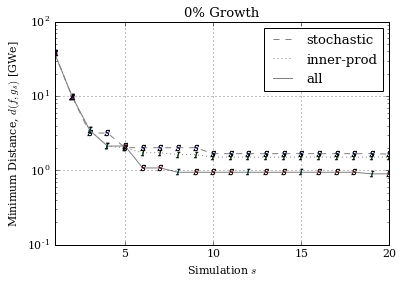

In [19]:
convergence_plot([state0sto, state0inn, state0all], linestyles, labels, 0)

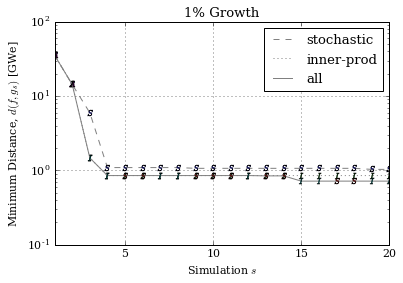

In [20]:
convergence_plot([state1sto, state1inn, state1all], linestyles, labels, 1)

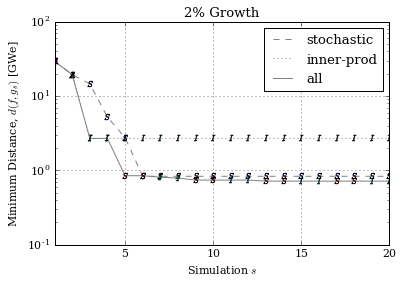

In [21]:
convergence_plot([state2sto, state2inn, state2all], linestyles, labels, 2)

In [22]:
def demand_product(states, title):
    rates = [0, 1, 2]
    colors = ['k', 'green', 'purple']
    for state, color, rate in zip(states, colors, rates):
        f = state['f']
        g = state['G'][0]
        h = state['G'][1]
        t = 2016 + np.arange(len(g))
        plt.plot(t, f, linestyle='--', color=color)
        plt.plot(t, g, linestyle='-', color=color, label='{}% growth'.format(rate))
        plt.plot(t, h, linestyle=':', color=color)
    plt.legend(loc=0)
    plt.axis([2016, 2015+T, 80, 150])
    plt.xlabel('time [year]')
    plt.ylabel('Power [GWe]')
    plt.title(title + ' Method')
    fname = 'demand-product-{}'.format(make_fname_safe(title))
    plt.savefig(fname + '.eps')
    plt.savefig(fname + '.png')

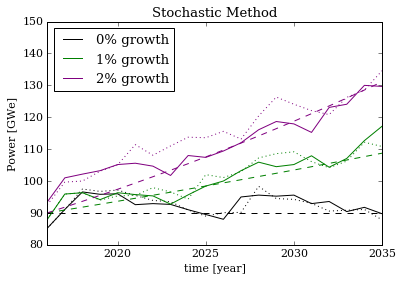

In [23]:
demand_product([state0sto, state1sto, state2sto], 'Stochastic')

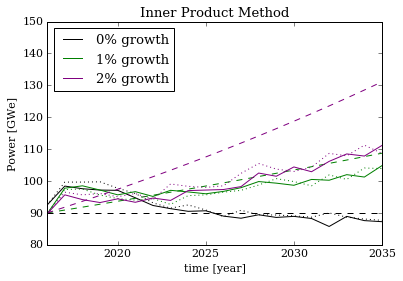

In [24]:
demand_product([state0inn, state1inn, state2inn], 'Inner Product')

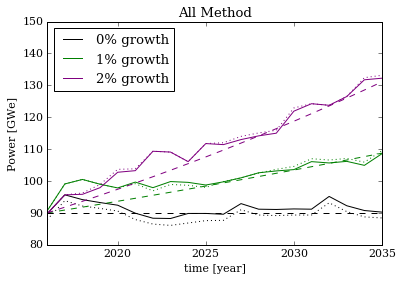

In [25]:
demand_product([state0all, state1all, state2all], 'All')

In [26]:
def deploy_plot(states, labels, colors, r):
    width = 0.8 / len(states)
    for i, state, label, color in zip(range(len(states)), states, labels, colors):
        tgrid = np.arange(2015, 2015+state['T'])
        plt.bar(tgrid + i*width, state['Θs'][0], width, label=label, color=color)
    ax = plt.axis()
    plt.axis(ax[:2] + (0, 12))
    plt.legend(loc=0)
    plt.grid(axis='y')
    plt.xlabel('time [year]')
    plt.ylabel('Number of Deployed LWRs, $\Theta$')
    plt.title('{}% Growth'.format(r))
    fname = 'deploy-{}'.format(r)
    plt.savefig(fname + '.eps')
    plt.savefig(fname + '.png')
        
dlabels = ['stochastic', 'inner-prod', 'all']
dcolors = ['k', 'green', 'purple']

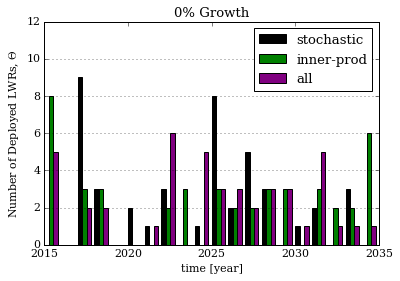

In [27]:
deploy_plot([state0sto, state0inn, state0all], dlabels, dcolors, 0)

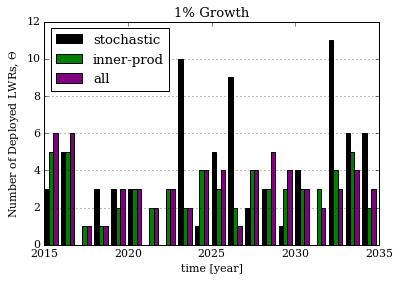

In [28]:
deploy_plot([state1sto, state1inn, state1all], dlabels, dcolors, 1)

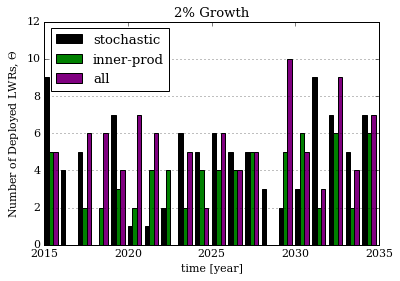

In [29]:
deploy_plot([state2sto, state2inn, state2all], dlabels, dcolors, 2)

In [30]:
#%time state0all5 = run_percent_growth(0, T=5, MAX_S=20, method_0='all')

In [31]:
#%time state0all10 = run_percent_growth(0, T=10, MAX_S=20, method_0='all')

In [32]:
#%time state0all15 = run_percent_growth(0, T=15, MAX_S=20, method_0='all')

In [33]:
#%time state0all50 = run_percent_growth(0, T=50, MAX_S=20, method_0='all')

In [34]:
def time_horizon_plot(states):
    x, y = [], []
    for state in states:
        x.append(state['T'])
        y.append(state['D'][0])
    plt.plot(x, y, 'k-')

In [35]:
#time_horizon_plot([state0all5, state0all10, state0all15, state0all, state0all50])